In [1]:
import keras
from keras.layers import *
import matplotlib.pyplot as plt
import numpy as np
import keras.utils
import keras_tuner
import tensorflow
from tensorflow.keras.preprocessing import image

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

In [4]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8 )
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256 )
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log" )
    optimizer = hp.Choice("optimizer", values=["adam", "sgd"])
    if optimizer=="adam":
       optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
    else:  
        optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
    model = tensorflow.keras.Sequential()
    model.add (tensorflow.keras.layers.Flatten())
    for i in range (n_hidden):
        model.add(tensorflow.keras.layers.Dense(n_neurons, activation="relu"))
    for i in range (n_hidden):
        model.add(tensorflow.keras.layers.Dense(n_neurons, activation="tanh"))
    model.add(tensorflow.keras.layers.Dense(10, activation="softmax"))    
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [5]:
random_search_tuner=keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials = 10,
    overwrite=True,
    seed=37
)

In [6]:
random_search_tuner.search(x_train, y_train, epochs=10, validation_split=0.2)

Trial 10 Complete [00h 01m 02s]
val_accuracy: 0.8877500295639038

Best val_accuracy So Far: 0.8877500295639038
Total elapsed time: 00h 10m 03s


In [7]:
best_model=random_search_tuner.get_best_models()[0]

In [8]:
results = random_search_tuner.oracle.get_best_trials()[0]
results.summary()

Trial 09 summary
Hyperparameters:
n_hidden: 2
n_neurons: 223
learning_rate: 0.000797425773423712
optimizer: adam
Score: 0.8877500295639038


In [9]:
best_model.fit(x_train, y_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2651 - accuracy: 0.9014
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2518 - accuracy: 0.9054
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2396 - accuracy: 0.9087
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2311 - accuracy: 0.9130
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2207 - accuracy: 0.9162
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2156 - accuracy: 0.9183
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2071 - accuracy: 0.9212
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1998 - accuracy: 0.9235
Epoch 9/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1933 - accuracy: 0.9265
Epoch 10/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.190

In [11]:
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3911 - accuracy: 0.8891


In [17]:
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize.
train_images = (train_images / 255)
test_images = (test_images / 255)
test_acc = best_model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.3911 - accuracy: 0.8891 - 722ms/epoch - 2ms/step



Test accuracy: [0.39106711745262146, 0.8891000151634216]
313/313 [==============================] - 1s 1ms/step


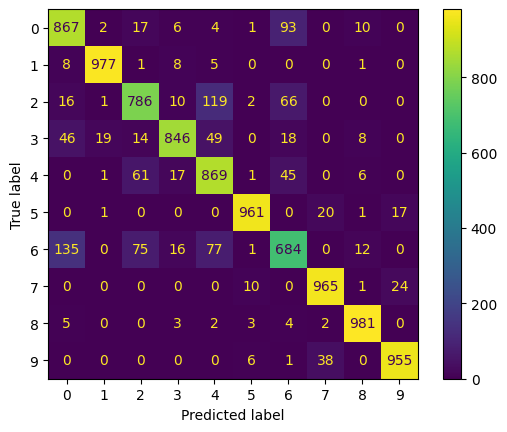

In [18]:
print('\nTest accuracy:', test_acc)
  # Получим предсказания
probability_model = tensorflow.keras.Sequential([best_model,
                                         tensorflow.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
# Посмотрим на результаты
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)